In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from data_visualisation import *
from data_filtration import *
import matplotlib.image as mpimg

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df = df[df.UUID == 'b9407f30f5f8466eaff925556b57fe6d']

In [4]:
straight_line = df[df.SessId == 32]
standing_still = df[df.SessId == 31]

In [5]:
df = df[df.SessId != 32]
df = df[df.SessId != 31]

In [6]:
img = mpimg.imread('cropped_flat.png')

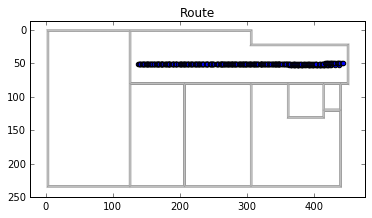

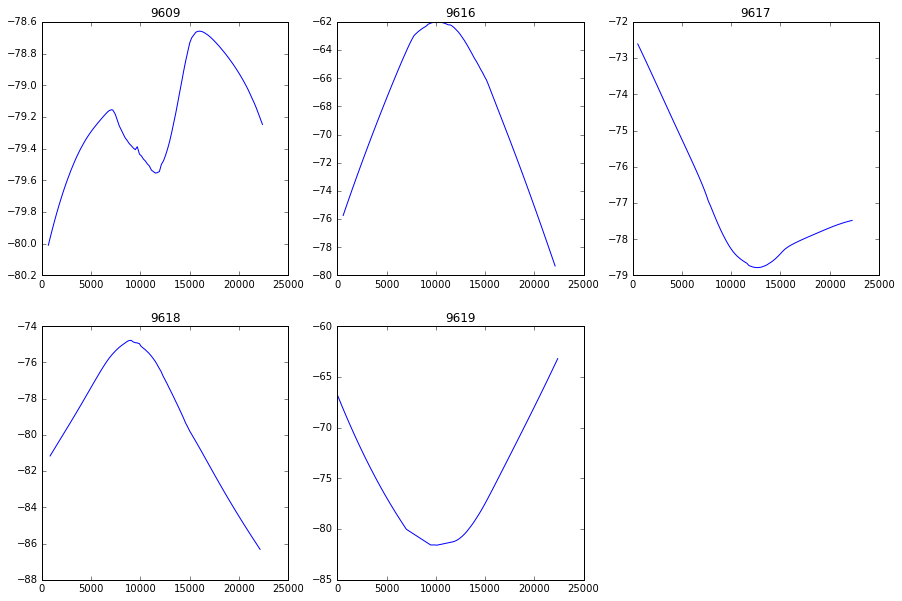

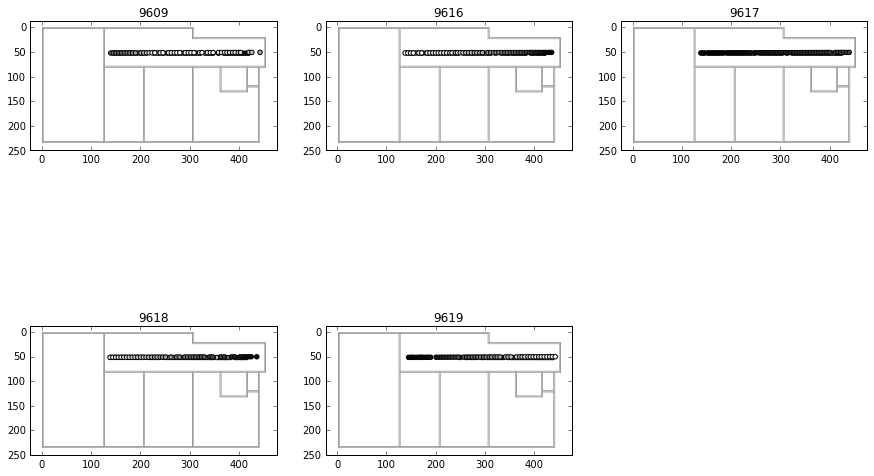

In [7]:
plot_session(straight_line, img, filter_func=rssi_lowess_filter)

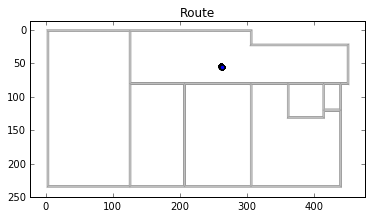

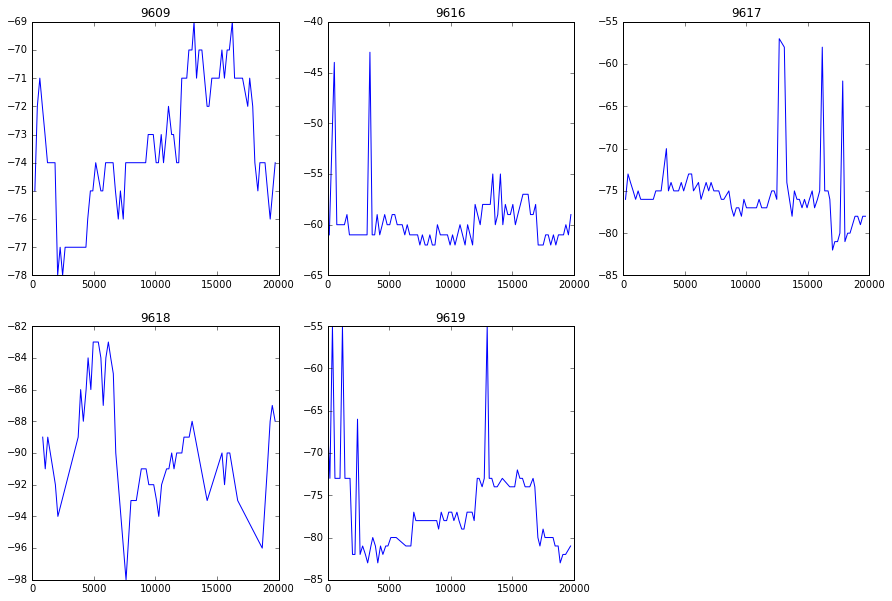

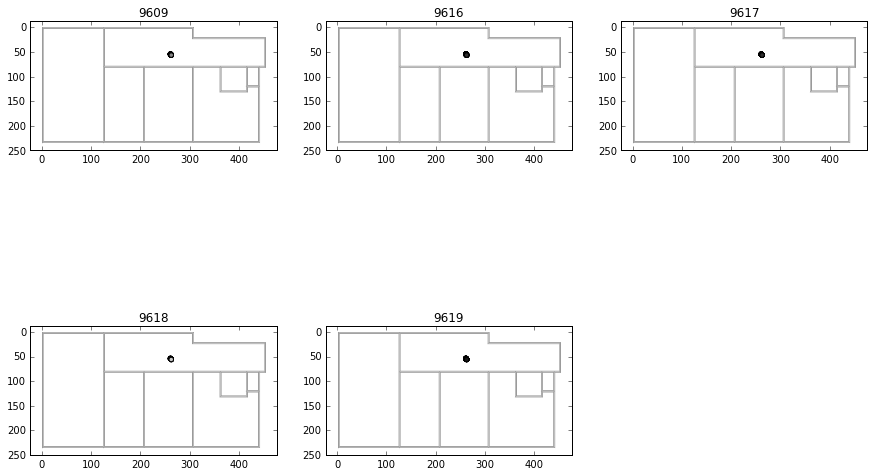

In [10]:
plot_session(standing_still, img)

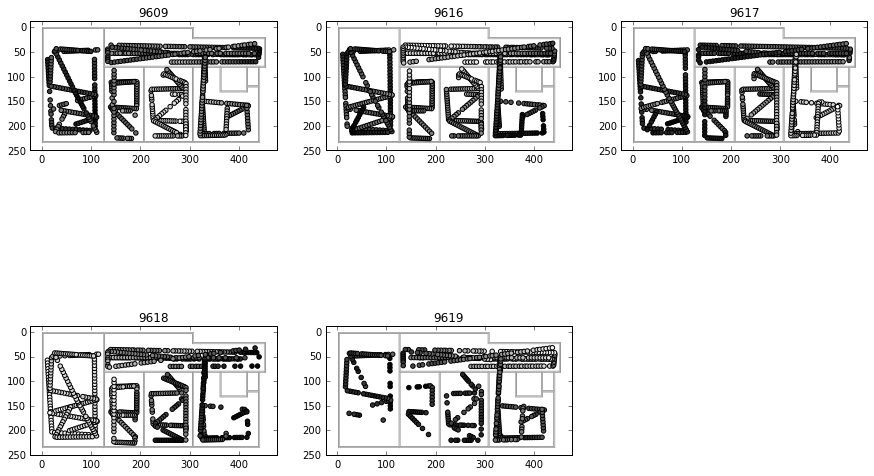

In [9]:
plot_rssi_map(df, img, filter_func=create_rssi_avg_filter(21))